In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation, writers
import numpy as np

In [326]:
import os
from scipy.optimize import minimize
import sys

def find_all_paths(directory):
    paths = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            paths.append(name)
        for name in dirs:
            paths.append(name)
    return paths

class data_file:
    def __init__(self, directory_path, path):
        self.path = path
        self.directory_path = directory_path
        self.full_path = os.path.join(directory_path, path)
        self.plots_directory = os.path.join('Plots', directory_path)
        self.x_lim_min = 0
        self.x_lim_max = 3800
        self.y_lim_min = -1
        self.y_lim_max = 1
        self.show_plots = True  # Attribute to control plot display
        self.save_plots = False
        self.show_combined = False
        self.print_bool = False
        self.clean_bool = True
        
        # Constants for calculations
        self.M_disc = 0.832
        self.Br = 0
        self.L = 560/1000
        self.E = 2e11
        self.r_shaft = 9.55/(2*1000)
        self.rho = 7900
        self.r_disc = 76.02/(2*1000)
        self.eccentricity = 0.25 # estimated from the data

        self.nu = 10 # damping
        self.ro = 38.5826 / 2000  # [mm]
        self.brass_OD = 15.875 / 2000  # [mm]
        self.ri = 9/2000
        self.A = 0.00955 * 0.019  # [m^2] Cross-sectional area of the bearing
        self.L_bearing = 0.019  # [m] bearing length
        self.hole_base = 5.3252/100
        self.block = self.hole_base-self.ro/1000
        self.E_al = 70e9
        self.E_brass = 90e9
        self.brass_thickness = self.brass_OD-self.ri
        self.normalise_rpm_by_max_displacement = True
        self.normalise_eccentricity = True

        if 'additive' in self.path.lower():
            self.E_only = 190e9
            self.d = 19E-3
            self.E = self.block*self.E_al+self.brass_thickness*self.E_brass+self.E_only
        elif 'aluminium' in self.path.lower():
            # self.E = 90e9*0.1+70e9*0.9  # Aluminium
            self.E_only = 90e9  # Aluminium
            self.d = 27E-3
            self.E = self.block*self.E_al+self.brass_thickness*self.E_brass+self.E_only
        elif 'plastic' in self.path.lower():
            # self.E = 10e9*0.1+70e9*0.9  # Plastic
            self.E_only = 90e9  # Plastic
            self.d = 15E-3
            self.E = self.block*self.E_al+self.brass_thickness*self.E_brass+self.E_only
        elif 'ball_bearing' in self.path.lower():
            self.E = 220e9  # High carbon chromium bearing steel
            self.d = 27E-3
        # Constants for flexible support calculations
        print('E:', self.E)
        
        # Calculations
        self.calculate_dynamics()  # Existing calculations
        self.calc_stiffness()
        self.jeffcott_rotor_model_flexible()
        
    
        
    def read(self):
        if self.full_path.endswith('.csv'):
            self.data = pd.read_csv(self.full_path)
            # print('Read as .csv')
        elif self.full_path.endswith('.xlsx'):
            self.data = pd.read_excel(self.full_path)
            # print('Read as .xlsx')
        else:
            print('Provide file as .csv or .xlsx (excel format). ', self.path,' is not a readable format.')
        
    def calculate_dynamics(self):
        self.M_shaft = math.pi * self.r_shaft**2 * self.L * self.rho
        self.I_z_disc_A = math.pi * (self.r_disc**4 - self.r_shaft**4) / 4
        self.I_z_shaft_A = math.pi * (self.r_shaft**4) / 4
        self.Kr = 2* 48 * self.E * (self.I_z_shaft_A) / self.L**3
        self.Wn = math.sqrt(self.Kr / self.M_disc)
        self.RPM_n = self.Wn * 60 / (2 * math.pi)
        self.zeta = self.Br / (2 * self.M_disc * self.Wn)
        self.W = np.arange(0, 5000, 10)
        self.rb_div_e = (self.W/self.Wn)**2 / np.sqrt((1 - (self.W/self.Wn)**2)**2 + 2 * self.zeta * (self.W/self.Wn)**2)

    def print_rigid_dynamics(self):
        print('For the rigid bearing supports')
        print('Wn: ', self.Wn)
        print('RPM:', self.Wn * 60 / (2 * math.pi))
        
    def calc_stiffness(self):
        h = 0.25/1000
        L = 10/1000
        OD = 38.5826/(2*1000)
        ID = 15.875/(2*1000)
        I = L*h**3/12
        self.E_f = 48*self.E*I*2*(OD-self.ri*2)/(4*math.pi*(self.d)*L**3*self.ri*2)
        A = 2*math.pi*ID/2*self.d # 2 bearing supports
        self.Ks = A*self.E_f/self.d 

    def jeffcott_rotor_model_flexible(self):
        self.Wc = np.sqrt(self.Ks / self.M_disc)
        self.RPM_c = self.Wc * 60 / (2 * math.pi)
        self.kappa = self.Ks / self.Kr
        self.c1 = 1 - (1 + self.kappa) * (self.W / self.Wc) ** 2
        self.c2 = 1 - (self.W / self.Wc) ** 2 * self.kappa
        self.c3 = 2 * self.W / self.Wc * self.nu
        self.ra_div_e = (self.W / self.Wc) ** 2 / np.sqrt(self.c1 ** 2 + (self.c3 * self.c2) ** 2)
        self.rb_div_e = self.ra_div_e * np.sqrt((1 + self.kappa) ** 2 + (self.c3 * self.kappa) ** 2)

    def print_flexible_dynamics(self):
        print('For the flexible bearing supports')
        print(f'Wc: {self.Wc}, RPM: {self.RPM_c}')
        print(f'Wn: {self.Wn}, RPM: {self.RPM_n}')
        
    def plot_response_flexible(self, axis, fig_num, xlabel, ylabel, xlimits=[0, 5], ylimits=[0, 15]):
        if self.clean_bool:
            plt.figure(fig_num)
            # plt.plot(self.W/self.Wc, self.rb_div_e)
            plt.plot(self.W/(self.rpm_factor*(2*math.pi)/60), self.rb_div_e, label=r'$\nu = {:.2f}, \epsilon = {:.2f}$'.format(self.nu, self.eccentricity))
            # plt.plot(self.W/(2*math.pi)*60, self.rb_div_e)
            title_suffix = 'r'
            if self.normalise_rpm_by_max_displacement:
                normalised = 'normalised_by_RPM'
            else:
                normalised = ''
            plt.title(f'Flexible Rotor radial displacement against RPM: ' + (self.path).split('.')[0])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
            # plt.xlim(xlimits)
            # plt.ylim(ylimits)
            if self.save_plots:
                plt.savefig(os.path.join(self.plots_directory, f"{self.path.split('.')[0]}_{title_suffix}_flexible_response_{normalised}.png"))
        if self.show_plots == True:
            plt.show()

    def plot_r_clean_scatter_max(self, axis='r'):
        
        filtered_data = self.data[(self.data[self.data.columns[0]].between(-100, 100)) & 
                          (self.data[self.data.columns[1]].between(-100, 100))]

        # Replace the original DataFrame with the filtered DataFrame
        self.data = filtered_data

        # Optionally, reset the index if you want a clean, consecutive index after filtering
        self.data.reset_index(drop=True, inplace=True)
        
        if self.print_bool:
            print("Max value before squaring:", np.max(self.data[self.data.columns[0]]))
            print("Min value before squaring:", np.min(self.data[self.data.columns[0]]))
            print("Max value after squaring:", np.max(np.square(self.data[self.data.columns[0]])))
            print("Min value after squaring:", np.min(np.square(self.data[self.data.columns[0]])))

            # Also, directly check for any infinities or NaNs
            print("Infinities in data:", np.isinf(self.data[self.data.columns[0]]).any())
            print("NaNs in data:", np.isnan(self.data[self.data.columns[0]]).any())
        
        """Plots a clean scatter diagram showing max for either x or y displacement, with optional normalizations."""
        self.data['r'] = (np.sqrt(np.square(np.abs(self.data[self.data.columns[0]]))+np.square(np.abs(self.data[self.data.columns[1]]))))
        # Normalize by eccentricity if required
        if self.normalise_eccentricity:
            self.factor = self.eccentricity
            # print(factor)
            ylabel = f'displacement {axis} (normalized by eccentricity)'
        else:
            self.factor = 1
            ylabel = f'displacement {axis}'

        # Normalize RPM by the index at max displacement if required
        if self.normalise_rpm_by_max_displacement:
            # Filter 'r' where 'rpm' is between 800 and 2000
            # Assume 'rpm' is the column name; replace with self.data.columns[index] if it's not named
            condition = (self.data[self.data.columns[2]] >= 800) & (self.data[self.data.columns[2]] <= 2000)
            filtered_r = self.data.loc[condition, 'r']

            # Check if there are any entries after filtering
            if not filtered_r.empty:
                # Find the index of the max value in 'r' within the filtered range
                self.rpm_factor = self.data[self.data.columns[2]][filtered_r.idxmax()]
            else:
                # Handle case where no data falls within the range
                self.rpm_factor = 1  # Default or error handling
        else:
            self.rpm_factor = 1
        
        print('Crtical RPM: ', self.rpm_factor)

        self.data = self.data.dropna()
        grouped_data = self.data.groupby(self.data.columns[2])
        self.max_min_data = grouped_data['r'].agg(['max', 'min']).interpolate(method='linear')
            
        if self.clean_bool:
            plt.scatter(self.max_min_data.index / self.rpm_factor, self.max_min_data['max'] / self.factor, color='red', label='r', s=0.1)
            plt.plot(self.max_min_data.index / self.rpm_factor, self.max_min_data['max'] / self.factor, color='red', linewidth=1)
        else:
            plt.scatter(self.data[self.data.columns[2]] / self.rpm_factor, self.data['r'] / self.factor, color='red', label='r', s=1)
            # plt.plot(self.data[self.data.columns[2]] / self.rpm_factor, self.data['r'] / self.factor, color='red', linewidth=1)
        
        plt.xlabel('Normalized RPM' if self.normalise_rpm_by_max_displacement else 'RPM')
        plt.ylabel(ylabel)
        title_suffix = 'r'
        plt.title(f'Flexible Rotor radial displacement against RPM: ' + (self.path).split('.')[0])
        if self.clean_bool:
            plt.xlim([self.x_lim_min / self.rpm_factor, self.x_lim_max / self.rpm_factor])
            plt.ylim([0, 15])
        else:
            plt.ylim([0,10])
        plt.legend()
        if self.normalise_rpm_by_max_displacement:
            normalised = 'normalised_by_RPM'
        else:
            normalised = ''
        if self.show_plots == True:
            if self.clean_bool:
                plt.ylim([0,15])
            else:
                plt.ylim([0,10])
            plt.show()
        if self.save_plots:
            plt.savefig(os.path.join(self.plots_directory, f"{self.path.split('.')[0]}_{title_suffix}_flexible_response_{normalised}.png"))
    
    def fit_lorentzian_and_calculate_damping(self):
        # Filter the data for the x-range of interest
        peak_data = (self.max_min_data.index / self.rpm_factor > 0.75) & (self.max_min_data.index / self.rpm_factor < 1.25)
        x_peak = self.max_min_data.index[peak_data] / self.rpm_factor
        y_peak = self.max_min_data['max'][peak_data] / self.factor


        initial_guesses = [1.0, 0.1, max(y_peak) - min(y_peak), self.eccentricity]

        # Bounds for each parameter: x0, gamma, A, baseline
        lower_bounds = [0, 0, 0, self.eccentricity]  # Ensure baseline never goes below self.eccentricity
        upper_bounds = [np.inf, np.inf, np.inf, np.inf]  # Upper bounds are not restricted

                
        def lorentzian(x, x0, gamma, A, baseline):
            return (A / np.pi) * (gamma / ((x - x0)**2 + gamma**2)) + baseline

        # Fit the Lorentzian to the peak with bounds
        params, params_covariance = curve_fit(lorentzian, x_peak, y_peak, p0=initial_guesses, bounds=(lower_bounds, upper_bounds), maxfev=5000)
        
        # Extract the parameters
        x0_fit, gamma_fit, A_fit, baseline_fit = params

        # Calculate the damping ratio
        damping_ratio = gamma_fit / (2 * x0_fit)

        # Output results
        print(f"Fitted Lorentzian Parameters: x0 = {x0_fit}, gamma = {gamma_fit}, A = {A_fit}, baseline = {baseline_fit}")
        print(f"Estimated Damping Ratio: {damping_ratio}")

        # Optional: Plot the results
        plt.scatter(x_peak, y_peak, color='red', label='Data', s=0.1)
        plt.plot(np.linspace(0,5,100), lorentzian(np.linspace(0,5,100), *params), color='blue', linewidth=1, label='Lorentzian Fit')
        plt.legend()
        if self.save_plots:
            title_suffix = 'r'
            if self.normalise_rpm_by_max_displacement:
                normalised = 'normalised_by_RPM'
            plt.savefig(os.path.join(self.plots_directory, f"{self.path.split('.')[0]}_{title_suffix}_flexible_response_{normalised}.png"))
        if self.show_plots:
            plt.show()
        if self.show_combined:
            plt.show()

    def plot_orbit(self):
        # Create figure and axis
        # fig, ax = plt.subplots()
        # ax.set_title('Orbit Plot of Rotor Centerline')
        # ax.set_xlabel('X Displacement (mm)')
        # ax.set_ylabel('Y Displacement (mm)')
        # ax.grid(True)
        
        # Filter the data according to your condition
        # condition = (self.data[self.data.columns[2]] <= 800) & (self.data[self.data.columns[2]] <= 3000)
        # x = self.data.loc[condition, self.data.columns[1]].values
        # y = self.data.loc[condition, self.data.columns[2]].values
        x = self.data[self.data.columns[0]]
        y = self.data[self.data.columns[1]]
        
        # Set the plot limits
        # xlimits = 0.75
        ylimits = 1
        # plt.xlim([-xlimits, xlimits])
        plt.ylim([-ylimits, ylimits])

        plt.xlabel('Time /s')
        plt.ylabel('Displacement x /mm')
        plt.title('Displacement x against time: ' + (self.path).split('.')[0])

        plt.scatter(np.arange(len(x))/10000, x,s=0.01)
        # Show the plot with the animation
        title_suffix = 'Displacement x'
        plt.savefig(os.path.join(self.plots_directory, f"{self.path.split('.')[0]}_{title_suffix}.png"))
        plt.show()

        ylimits = 1
        # plt.xlim([-xlimits, xlimits])
        plt.ylim([-ylimits, ylimits])

        plt.xlabel('Time /s')
        plt.ylabel('Displacement y /mm')
        plt.title('Displacement y against time: ' + (self.path).split('.')[0])

        plt.scatter(np.arange(len(y))/10000, y,s=0.01)
        title_suffix = 'Displacement y'
        plt.savefig(os.path.join(self.plots_directory, f"{self.path.split('.')[0]}_{title_suffix}.png"))
        plt.show()


    def print_bs(self):
        print('Bs is: ', self.nu*2*self.M_disc*self.Wc)


In [327]:
def run_all(material_index, directory_path_list, nu_list, eccentricity_list, show_plots_bool=False, save_plots_bool=True, norm_bool=True, max_data_bool=True, show_combined_bool=False):
    data_object_list = []
    
    all_paths = find_all_paths(directory_path_list[material_index])  
    # print("All paths in the folder:")

    for path in all_paths:
        data_object_list.append(data_file(directory_path_list[material_index], path))
        
    # for data_object in data_object_list:
    #     print(data_object.path)

    def data_print(data_object_list, index):
        data_object = data_object_list[index]
        data_object.read()
        data_object.show_plots = True
        # data_object.plot_x_clean_scatter_eccentricity()
        data_object.plot_x_clean_scatter_eccentricity()
        # data_object.plot_y_clean_scatter()
        
    def data_operate(data_object_list, axis, index, nu_list, eccentricity_list):
        data_object = data_object_list[index]
        data_object.read()
        
        if axis == 'r':
            data_object.nu = nu_list
            data_object.eccentricity = eccentricity_list
            
        data_object.calculate_dynamics() 
        data_object.calc_stiffness()
        data_object.jeffcott_rotor_model_flexible()
        data_object.show_plots = show_plots_bool
        data_object.save_plots = save_plots_bool
        data_object.clean_bool = max_data_bool
        data_object.show_combined = show_combined_bool
        # data_object.normalise_eccentricity = norm_bool
        data_object.normalise_rpm_by_max_displacement = norm_bool
        
        # data_object.plot_r_clean_scatter_max(axis=axis)
        # data_object.plot_r_clean_scatter()
        # data_object.plot_response_flexible(axis=axis, fig_num=1, xlabel='Speed Ratio w', ylabel='Whirl Amplification Factor r/E')
        # data_object.fit_lorentzian_and_calculate_damping()

        print('Nu:', nu_list)
        print('Eccentricity:', eccentricity_list)
        
        # data_object.jeffcott_rotor_model_flexible()
        # data_object.print_flexible_dynamics()
        # data_object.print_bs()
        data_object.plot_orbit()


    for i in range(len(all_paths)):
        data_operate(data_object_list, 'r', i, nu_list[material_index], eccentricity_list[material_index])


 
class RedirectStdoutToFile:
    def __init__(self, file_path):
        self.file_path = file_path

    def __enter__(self):
        self.old_stdout = sys.stdout
        sys.stdout = open(self.file_path, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self.old_stdout


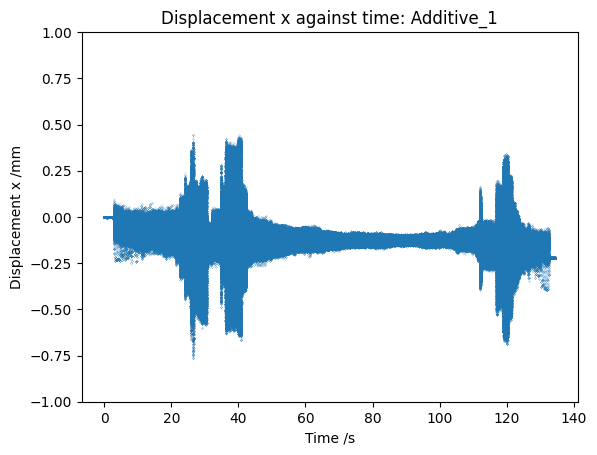

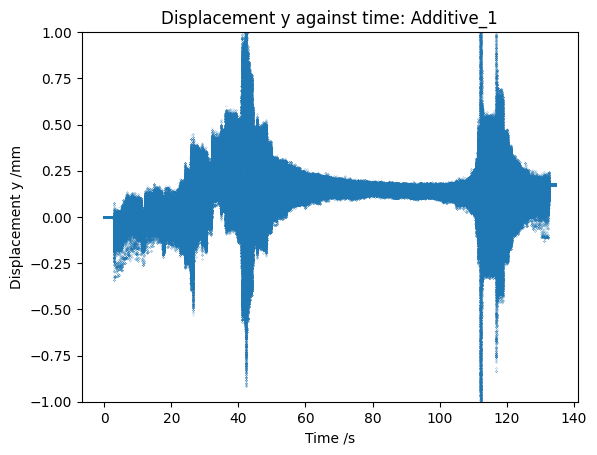

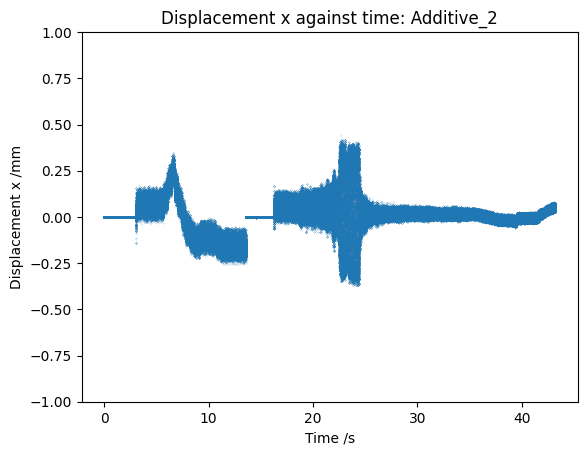

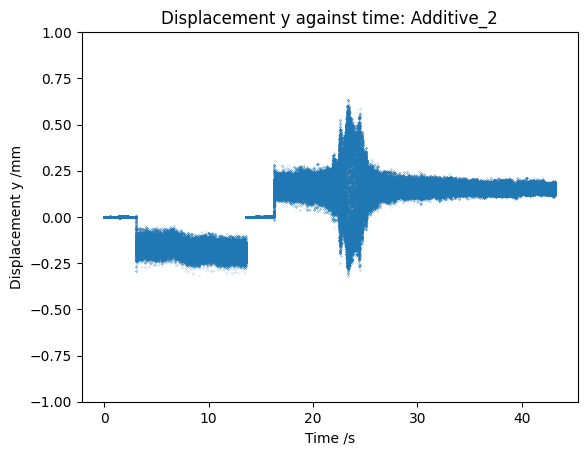

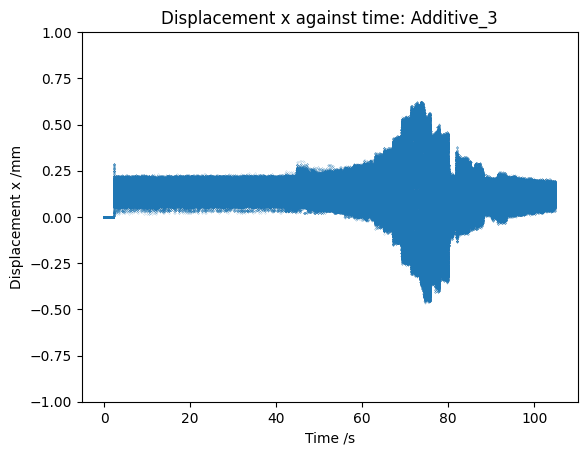

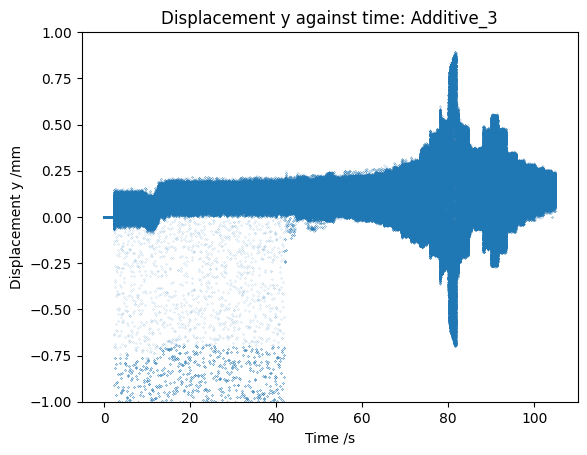

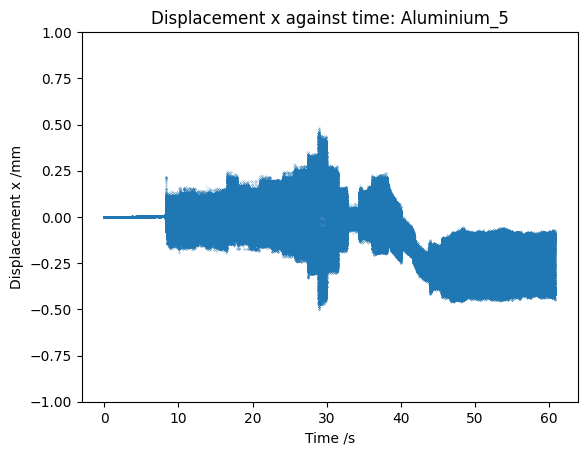

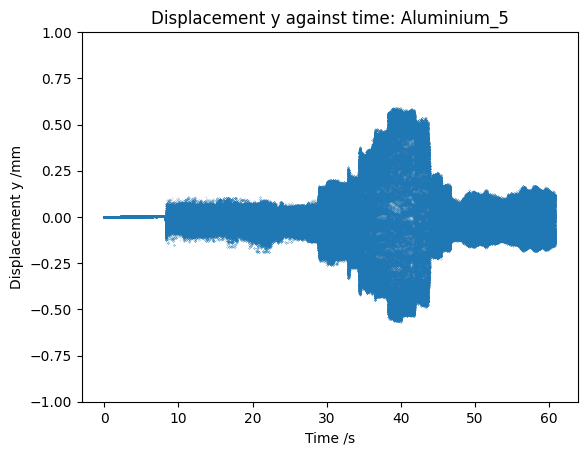

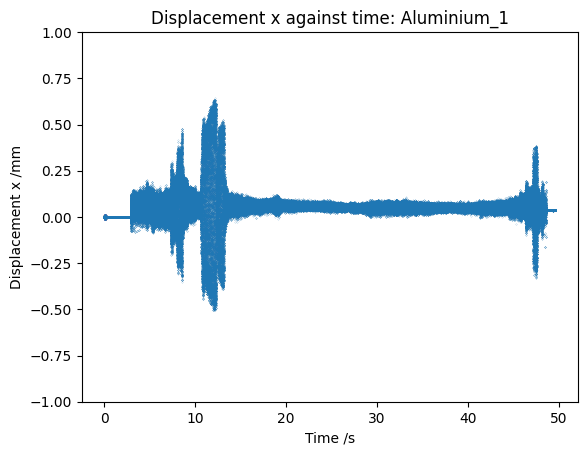

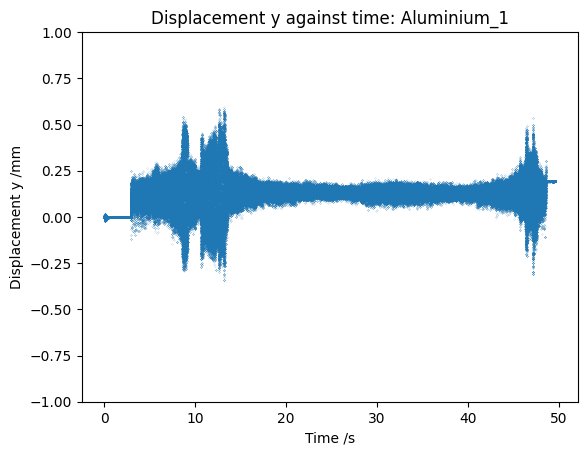

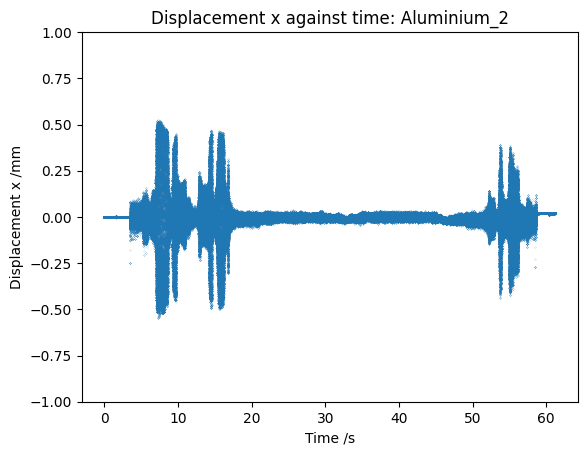

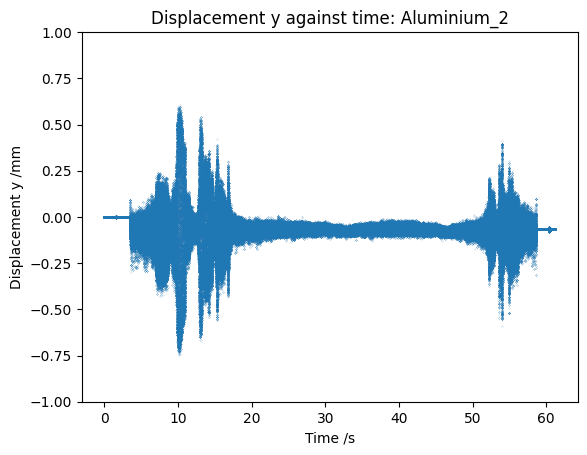

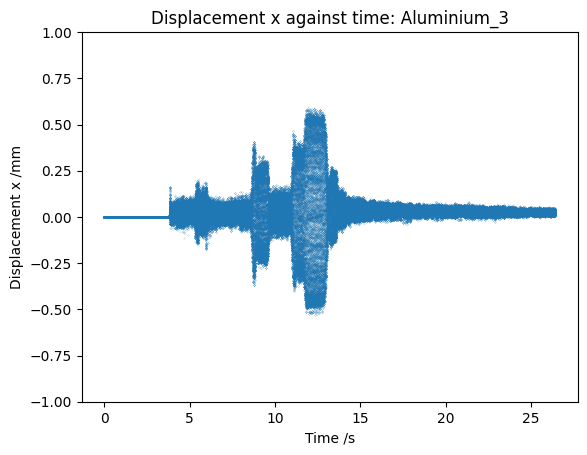

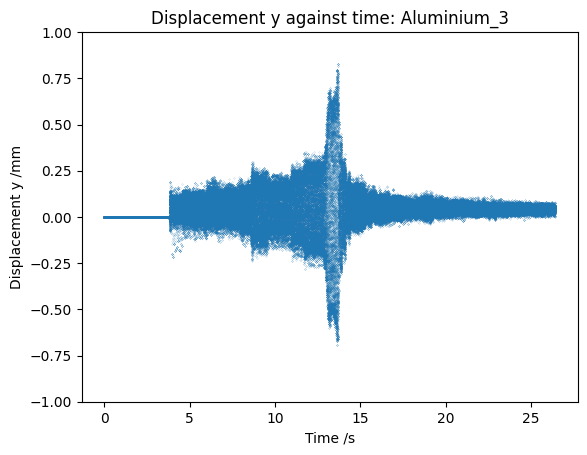

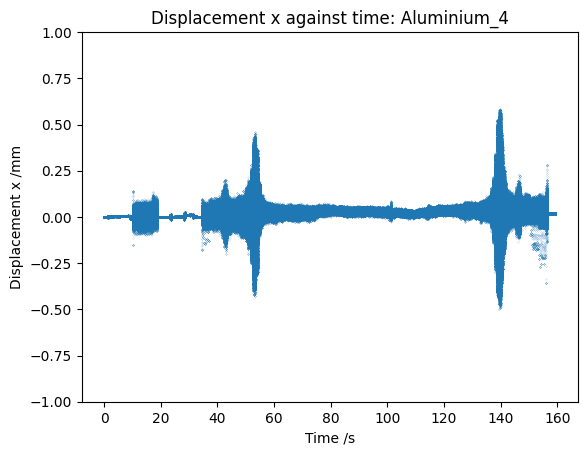

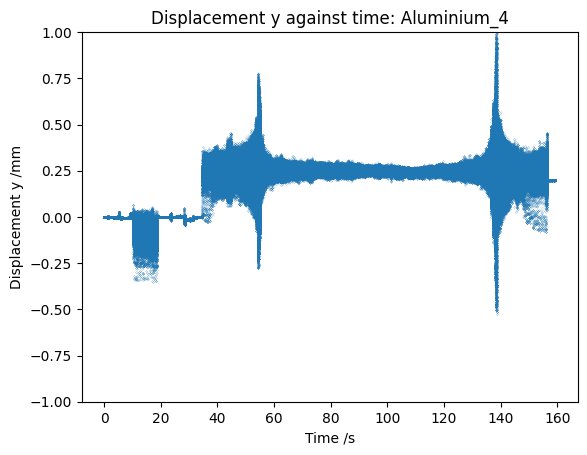

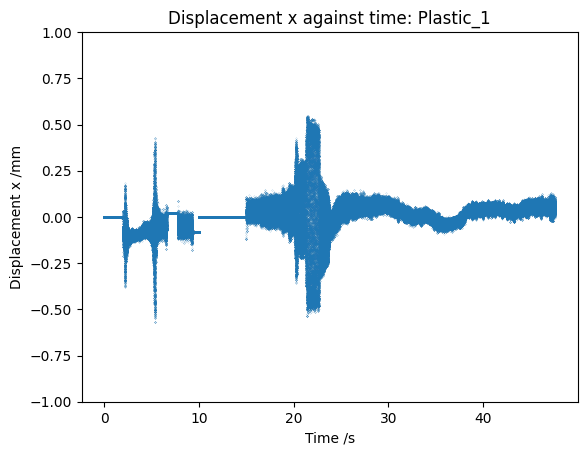

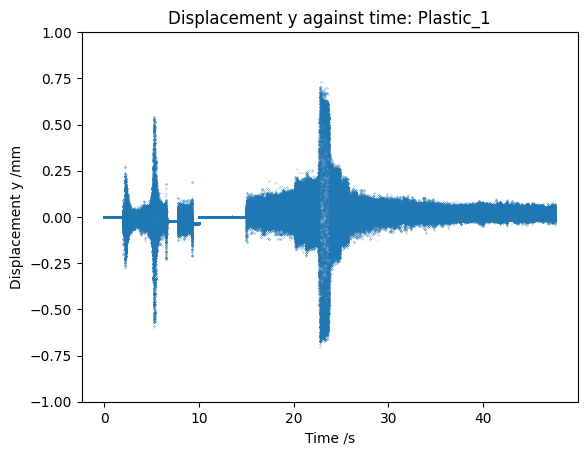

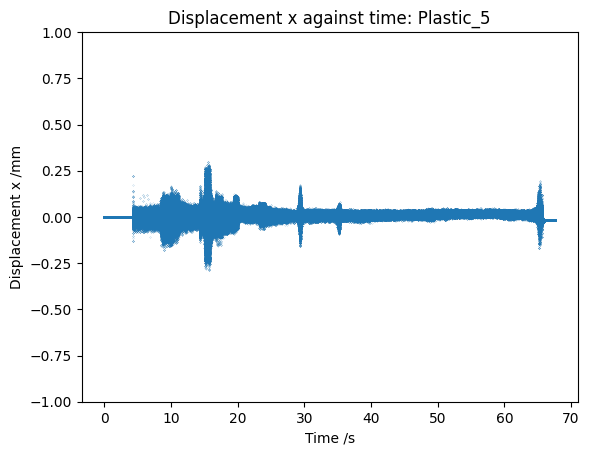

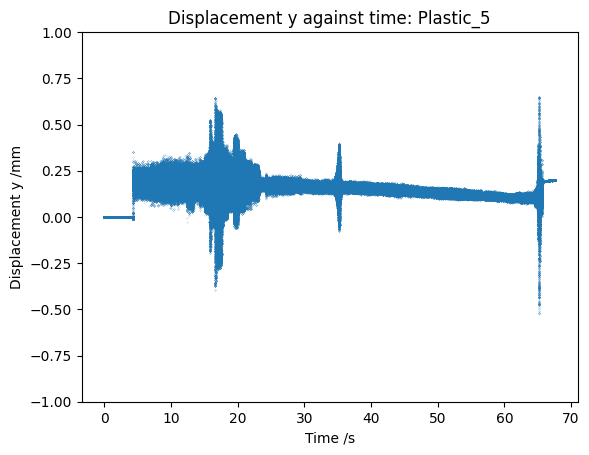

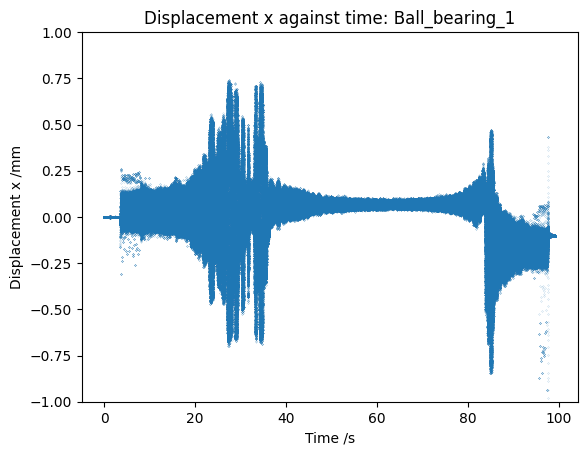

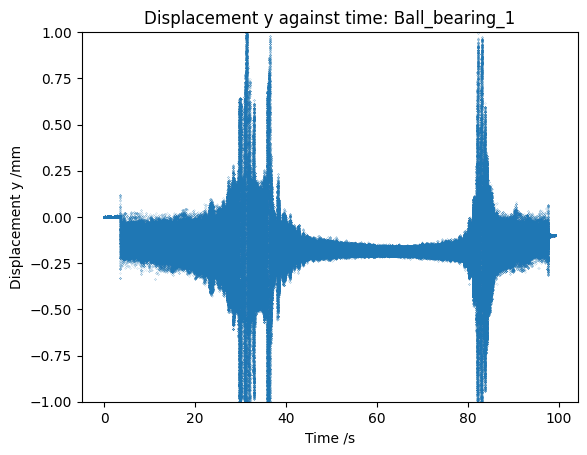

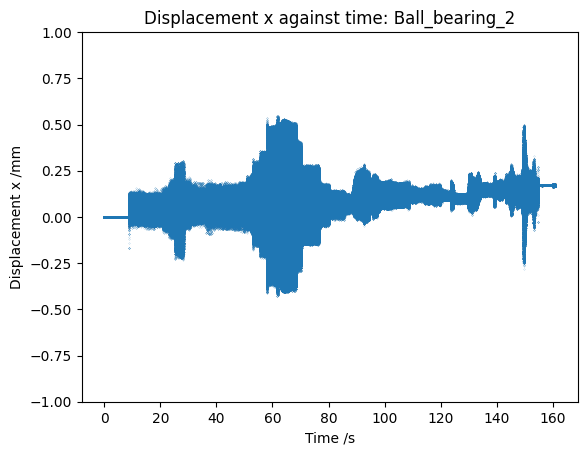

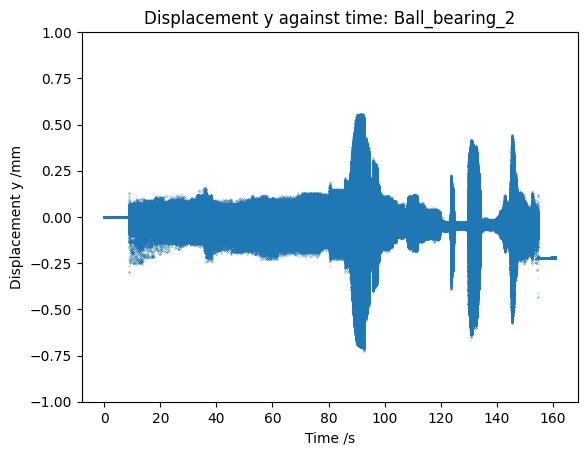

Output for iteration 3 has been written to output.txt


In [328]:
directory_path_list = ['Additive', 'Aluminium', 'Plastic', 'Bearing']
# directory_path_list = ['Additive']
nu_list = [0.3, 0.11, 0.15, 0.25]
eccentricity_list = [0.2, 0.1, 0.1, 0.19]

file_path = 'output.txt'  # The path for the output file
with RedirectStdoutToFile(file_path):
    for i in range(len(directory_path_list)):
        #replace this here with a function that opens a .txt files clear it all then writes all outputs
        print(directory_path_list[i])
        run_all(i, directory_path_list, nu_list, eccentricity_list, show_plots_bool=False, save_plots_bool=True, norm_bool=True, max_data_bool=True, show_combined_bool=True)
print(f"Output for iteration {i} has been written to {file_path}")